In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-proj-G83o8KfgDs6AYLdJJEavT3BlbkFJsZNRXkuczYp2mVTUY6t4'

os.environ["LANGSMITH_API_KEY"] = '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'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

#for internet request
os.environ['TAVILY_API_KEY'] = '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'

In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [6]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [7]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [8]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

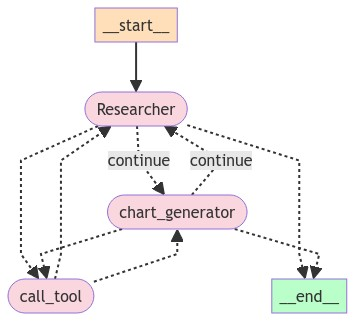

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XSwMBZJ72UwEjIrDdyjP8W4I', 'function': {'arguments': '{"query":"top 5 best selling video games of 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 267, 'total_tokens': 295}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-3a3e07de-247a-4377-a041-2053320ae1a2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'top 5 best selling video games of 2023'}, 'id': 'call_XSwMBZJ72UwEjIrDdyjP8W4I'}], usage_metadata={'input_tokens': 267, 'output_tokens': 28, 'total_tokens': 295})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.gamespot.com/gallery/the-20-best-selling-games-of-2023-in-the-us/2900-4951/", "content": "The franchise is more

c:\Users\titouan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\titouan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


{'call_tool': {'messages': [ToolMessage(content='Successfully executed:\n```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = {\'Game\': [\'MLB The Show 23\', \'Marvel\\\'s Spider-Man 2\', \'Sea of Stars\', \'Fire Emblem Engage\', \'Metroid Prime Remastered\'],\n        \'Copies Sold\': [\'Data Incomplete\', 5000000, 250000, 1610000, 1000000]}\n\ndf = pd.DataFrame(data)\n\nplt.figure(figsize=(10, 6))\nplt.bar(df[\'Game\'], df[\'Copies Sold\'])\nplt.xlabel(\'Game\')\nplt.ylabel(\'Copies Sold\')\nplt.title(\'Copies Sold of Top 5 Best Selling Video Games of 2023\')\nplt.xticks(rotation=45)\nplt.show()\n```\nStdout: TypeError("\'value\' must be an instance of str or bytes, not a int")\n\nIf you have completed all tasks, respond with FINAL ANSWER.', name='python_repl', tool_call_id='call_pQnjDPiMDql6a0lbaXOuzAjl')]}}
----
{'chart_generator': {'messages': [AIMessage(content='It seems there was an issue with the data format. I will correct this and rerun the code to gener

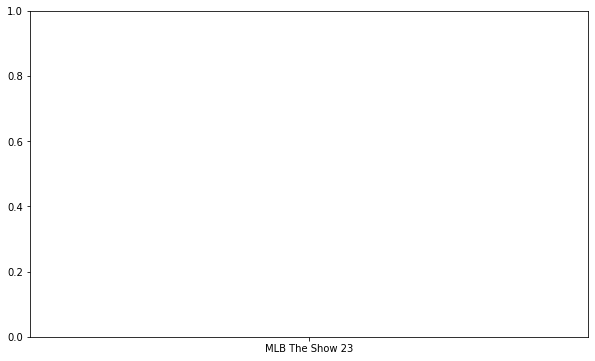

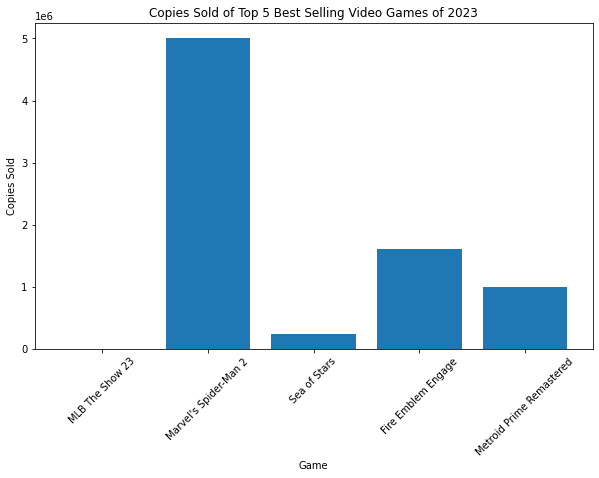

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = {'Game': ['MLB The Show 23', 'Marvel\\'s Spider-Man 2', 'Sea of Stars', 'Fire Emblem Engage', 'Metroid Prime Remastered'],\n        'Copies Sold': [0, 5000000, 250000, 1610000, 1000000]}\n\ndf = pd.DataFrame(data)\n\nplt.figure(figsize=(10, 6))\nplt.bar(df['Game'], df['Copies Sold'])\nplt.xlabel('Game')\nplt.ylabel('Copies Sold')\nplt.title('Copies Sold of Top 5 Best Selling Video Games of 2023')\nplt.xticks(rotation=45)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_0CT4HvklYTyKJZj234w9nmte')]}}
----
{'chart_generator': {'messages': [AIMessage(content='FINAL ANSWER', response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 5575, 'total_tokens': 5579}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 

In [20]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="fetch the name of the top 5 best selling video games of 2023"
                "fetch how many copies were sold in 2023 for each game"
                "the researcher cannot call chart_generator as a tool"
                "the researcher should finish its task and route the data to the chart_generator"
                "then code and plot a bar chart with this data (using python_repl)"
                "display the chart, then finish"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

**OBSERVATIONS**

when asked even a relatively simple task like fetching basic data and drawing a graph, it doesnt always work.
There seems to be a problem sometimes where the researcher doesnt call the chart_generator when it should.
This very basic prompt works as intended: 

                "i want a graph with random values on x and y axis"
                "write code for this graph"
                "display the graph, then finish"

This one does not, maybe too complicated:

                "fetch the name of the top 5 best selling video games of 2023"
                "fetch how many copies were sold in 2023 for each game"
                "once the data is found, transmit the data to the chart_generator"
                "then code and plot a bar chart with this data (using python_repl)"
                "display the chart, then finish"

Then i tried with this, but i had to be super explicit:

                "fetch the name of the top 5 best selling video games of 2023"
                "fetch how many copies were sold in 2023 for each game"
                "the researcher cannot call chart_generator as a tool"
                "the researcher should finish its task and route the data to the chart_generator"
                "then code and plot a bar chart with this data (using python_repl)"
                "display the chart, then finish"
                
!! these 'rules' or specifications should be included withing the agent's prompt probably. 
Also the researcher couldnt gather the real data, it seems like it looked on different websites and didnt even pick the best ones on each of them...
These graphs and agents are too simple for the task, we defintely need feedback agents, or double-checkers at least
see implementation: https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/
